# Prerequisites

In [2]:
import os, sys

import numpy as np
import tqdm
import torch

Important paths for the notebook:

In [3]:
app_root = '../../../../'
test_name = 'test2_ernie'
datasets_path = os.path.join(app_root, 'data')
model_dir_path = os.path.join(app_root, 'model', test_name)

datasets_paths = {}
for lang in os.listdir(datasets_path):
    dataset_lang_path = os.path.join(datasets_path, lang)
    if os.path.isdir(dataset_lang_path):
        datasets_paths[lang] = {}
        for d_type in os.listdir(dataset_lang_path):
            d_name = d_type.split('.')[0]
            datasets_paths[lang][d_name] = os.path.join(dataset_lang_path, d_type)

In [4]:
sys.path.append('../../../')

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [5]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
global_params = {
    'batch_size': 32,
    'PAD_TOKEN': '<pad>',
    'UNK_TOKEN': '<unk>',
    'transformer_name': "nghuyong/ernie-2.0-en",
}

# Dataset

I will use ERNIE 2.0

In [7]:
from stud.modelsTests.dataset.SRLDataset_transformer import SRLDataset_transformer

In [9]:
dataset_train_en = SRLDataset_transformer(  datasets_paths['EN']['train'], 
                                            tokenizer = global_params['transformer_name'],
                                            baselines_file_path = os.path.join(app_root,'data/baselines.json'))
dataset_train_es = SRLDataset_transformer(  datasets_paths['ES']['train'], 
                                            tokenizer = dataset_train_en.tokenizer,
                                            labels = dataset_train_en.labels)
dataset_train_fr = SRLDataset_transformer(  datasets_paths['FR']['train'], 
                                            tokenizer = dataset_train_en.tokenizer,
                                            labels = dataset_train_en.labels)

In [10]:
SRLDataset_transformer.save_dict(
    os.path.join(model_dir_path, 'labels.npy'), 
    dataset_train_en.labels)

In [11]:
dataset_dev_en = SRLDataset_transformer(datasets_paths['EN']['dev'], 
                                        tokenizer = dataset_train_en.tokenizer,
                                        labels = dataset_train_en.labels)

In [12]:
next(iter(dataset_train_en)).keys()

dict_keys(['dependency_heads', 'dependency_relations', 'lemmas', 'pos_tags', 'predicates', 'roles', 'words', 'predicate_position', 'predicate_label', 'predicate_word'])

In [13]:
global_params.update({ 
    'n_roles_labels': len(dataset_train_en.labels['id_to_roles']),
    'n_predicates_labels': len(dataset_train_en.labels['id_to_predicates'])
})

Saving global variables...

In [14]:
np.save(os.path.join(model_dir_path, 'global_params.npy'), global_params)

# DataLoader

In [15]:
from torch.utils.data import DataLoader

In [16]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
num_workers = 4

In [17]:
dataloader_train_en = DataLoader(
    dataset_train_en,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

In [18]:
dataloader_dev_en = DataLoader(
    dataset_dev_en,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=False,
)

In [19]:
for e in dataloader_dev_en:
    ex_in = e
    break

In [20]:
ex_in.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'roles_formatted', 'matrix_subwords', 'output_mask', 'predicates', 'predicate_position', 'predicate_position_formatted', 'pos_tags'])

In [21]:
print(ex_in['input_ids'][0], ex_in['input_ids'].shape)
print(ex_in['output_mask'][0], ex_in['output_mask'].shape)
print(ex_in['roles_formatted'][0], ex_in['roles_formatted'].shape)

tensor([  101,  1996,  2837, 26021,  2008,  1996,  2110,  2283,  3477,  2062,
         3086,  2000, 12411, 28032,  6026,  1996,  2372,  1997,  1996,  2375,
         7285,  6736,  1010,  3036,  1998,  4273,  2749,  2055,  2529,  2916,
         1012,   102, 26021,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]) torch.Size([32, 78])
tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]) torch.Size([32, 78])
tensor([-1,  0,  1,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,


In [22]:
print(ex_in['predicates'][0], ex_in['predicates'].shape)
print(ex_in['predicate_position_formatted'][0], ex_in['predicate_position_formatted'].shape)

tensor([ -1,   0,   0, 162,   0,   0,   0,   0,   0,   0,   0,   0,   0,  -1,
         -1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1]) torch.Size([32, 78])
tensor(3) torch.Size([32])


In [23]:
torch.set_printoptions(edgeitems=80)
print(ex_in['matrix_subwords'].shape,'\n' , ex_in['matrix_subwords'][0][0:6,:10]) # word_ids[0:6] = [None, 0, 1, 2, 2, 3]
torch.set_printoptions(edgeitems=3)

torch.Size([32, 78, 78]) 
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


# Printing model

In [26]:
from torchinfo import summary

def print_summary(model):
    print(model)
    print('----------------------')
    p = sum(p.numel() for p in model.parameters())
    tp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    ntp = p - tp
    print('parameters:', f'{p:,}')
    print('trainable parameters:', f'{tp:,}')
    print('non-trainable parameters:', f'{ntp:,}')

import matplotlib.pyplot as plt

def display_history(dict_history):
    plt.figure(figsize=(8,8))
    for name, hist in dict_history.items():
        plt.plot([i for i in range(len(hist))], hist, label=name)
    plt.xlabel('epochs')
    plt.ylabel('value')
    plt.title('Model learning')
    plt.legend()
    plt.show()

In [27]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['roles_pad_id']) # !

# Training the Ernie based model

In [32]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_simple import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = False,
    loss_fn = loss_function,
    fine_tune_transformer=True,
    saves_path_folder = test_name,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(final_model.model.parameters(), lr=0.0016)

Some weights of the model checkpoint at nghuyong/ernie-2.0-en were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
print_summary(final_model.model)

Net_aic_transformer_simple(
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(4, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-0

In [34]:
history = {}

In [35]:
from stud.modelsTests.utils.Trainer_aic_transformer_simple import Trainer_aic_transformer_simple

trainer = Trainer_aic_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_en, dataloader_dev_en,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.81,
    save_path_name=os.path.join(model_dir_path, 'arg_iden_class_net_weights_ernie_en.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.245076
# Validation loss => 0.101371 | f1-score: arg_iden = 0.804329 arg_class = 0.503498 #
Epoch   1 => avg_loss: 0.097662
# Validation loss => 0.082017 | f1-score: arg_iden = 0.864165 arg_class = 0.604010 #
Epoch   2 => avg_loss: 0.083100
# Validation loss => 0.074666 | f1-score: arg_iden = 0.874543 arg_class = 0.631750 #
Epoch   3 => avg_loss: 0.074714
# Validation loss => 0.067823 | f1-score: arg_iden = 0.877828 arg_class = 0.655286 #
Epoch   4 => avg_loss: 0.068068
# Validation loss => 0.064224 | f1-score: arg_iden = 0.881901 arg_class = 0.676845 #
Epoch   5 => avg_loss: 0.062854
# Validation loss => 0.059245 | f1-score: arg_iden = 0.882467 arg_class = 0.703368 #
Epoch   6 => avg_loss: 0.058355
# Validation loss => 0.056064 | f1-score: arg_iden = 0.884832 arg_class = 0.724644 #
Epoch   7 => avg_loss: 0.054007
# Validation loss => 0.054270 | f1-score: arg_iden = 0.889180 arg_class = 0.739806 #
Epoch   8 => avg_loss: 0.050883
# Validation loss => 0.052657 | 

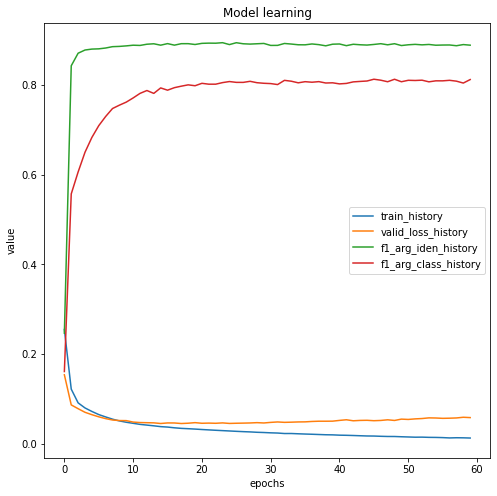

In [34]:
display_history(history)